# Preamble

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
from scipy.special import logsumexp
from scipy.stats import truncnorm
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Setup

In [3]:
# import MIST models
from brutus import filters
filters = filters.ps + filters.tmass
version_mist = 'v4.1'
filepath = '../data/grid_' + version_mist + '.h5'
models_mist, labels_mist, lmask_mist = brutus.load_models(filepath, filters=filters)
Nmodels_mist, Nbands_mist, Ncoef_mist = models_mist.shape

Reading filter 2MASS_Ks           


In [4]:
# import Bayestar models
version_bs = 'v1'
filepath = '../data/grid_bayestar_' + version_bs + '.h5'
models_bs, labels_bs, lmask_bs = brutus.load_models(filepath, filters=filters)
Nmodels_bs, Nbands_bs, Ncoef_bs = models_bs.shape

Reading filter 2MASS_Ks           


In [5]:
# replace reddening vector (CCM) for MIST with Eddie's version
models_mist[:, :, 0] = models_bs[:, :, 0][0]

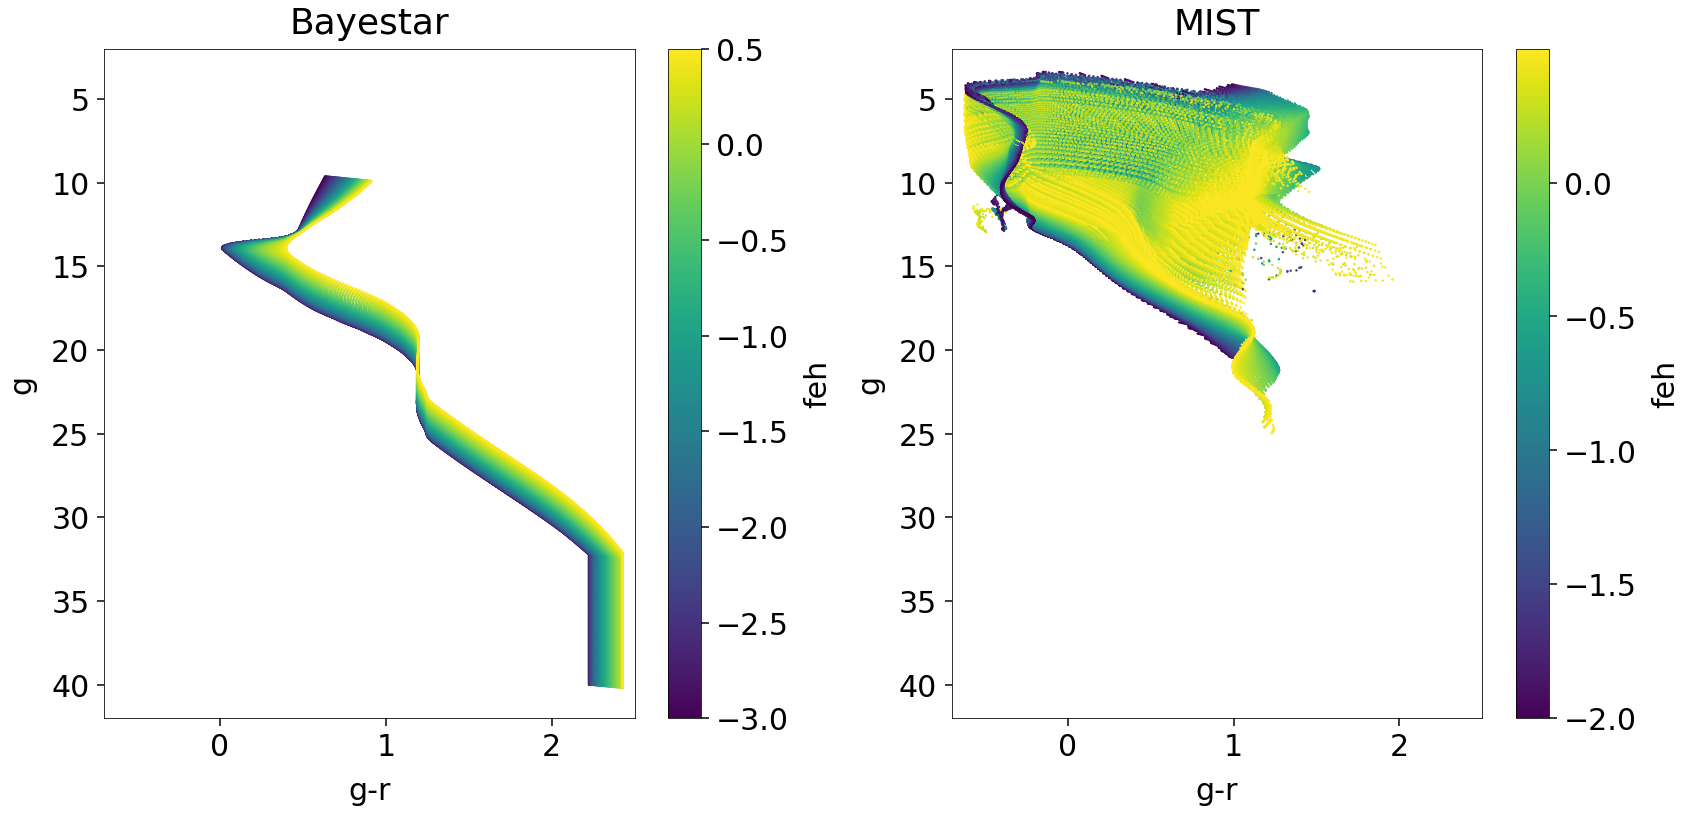

In [6]:
# plot CMDs
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
g_bs = models_bs[:, 0, -1]
r_bs = models_bs[:, 1, -1]
plt.scatter(g_bs - r_bs, g_bs, c=labels_bs['feh'], s=2)
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim([-0.7, 2.5])
plt.ylim([42, 2])
plt.colorbar(label='feh')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 2, 2)
g_mist = models_mist[:, 0, -1]
r_mist = models_mist[:, 1, -1]
plt.scatter(g_mist - r_mist, g_mist, c=labels_mist['feh'], s=2)
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim([-0.7, 2.5])
plt.ylim([42, 2])
plt.colorbar(label='feh')
plt.title('MIST')
plt.tight_layout()

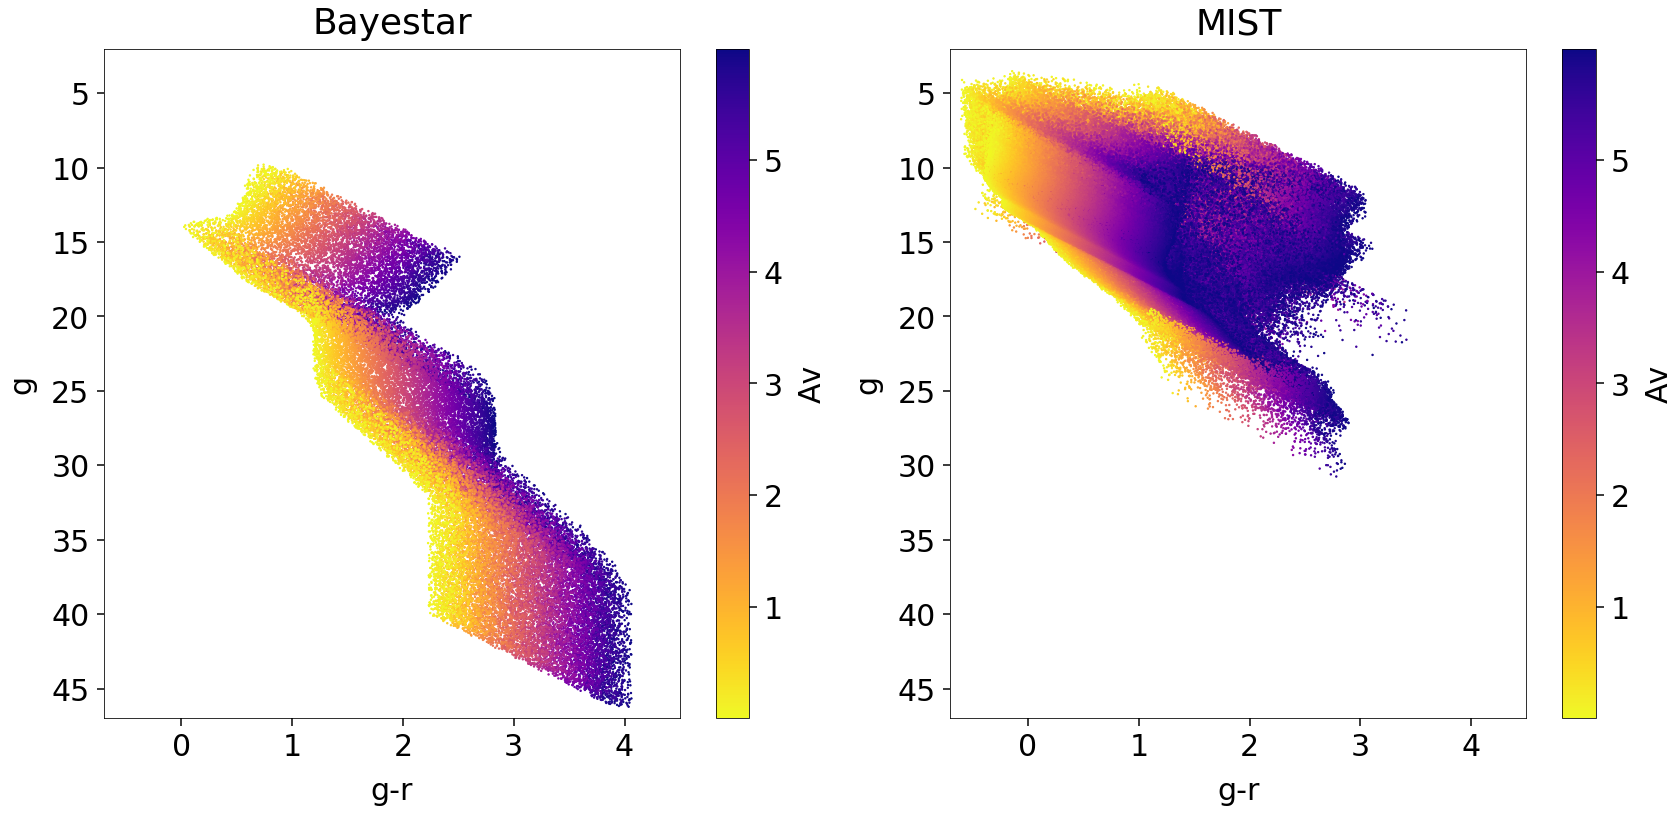

In [7]:
# plot reddened CMDs
from brutus import fitting

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
av = np.random.uniform(0, 6., Nmodels_bs)
seds = fitting.get_seds(models_bs, av=av)
g_bs, r_bs = seds[:, :2].T
plt.scatter(g_bs - r_bs, g_bs, 
            c=av, s=2, cmap='plasma_r')
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim([-0.7, 4.5])
plt.ylim([47, 2])
plt.colorbar(label='Av')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 2, 2)
av = np.random.uniform(0, 6., Nmodels_mist)
seds = fitting.get_seds(models_mist, av=av)
g_mist, r_mist = seds[:, :2].T
plt.scatter(g_mist - r_mist, g_mist, 
            c=av, s=2, cmap='plasma_r')
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim([-0.7, 4.5])
plt.ylim([47, 2])
plt.colorbar(label='Av')
plt.title('MIST')
plt.tight_layout()

# Data

In [8]:
# load in data
from brutus.utils import inv_magnitude
filename = '../data/Orion_Lam_l196.7_b-16.1'
f = h5py.File(filename+'.h5')
fpix = f['photometry']['pixel 0-0']
mag, magerr = fpix['mag'], fpix['err']
mask = np.isfinite(magerr)  # band mask
mag[~mask], magerr[~mask] = 0., 1.  # deal with missing data
phot, err = inv_magnitude(mag, magerr)  # convert assuming AB zero-point
objid = fpix['obj_id']
parallax, parallax_err = fpix['parallax'] * 1e3, fpix['parallax_error'] * 1e3  # convert to mas
psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)
print(Nobjs)

1498


# Stellar Posteriors

In [9]:
# load in fitter
from brutus.fitting import BruteForce
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs)
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist)

In [10]:
# Bayestar
t1 = time.time()
BF_bs.fit(phot, err, mask, objid, 
          filename+'_bayestar_'+version_bs,
          parallax=parallax, parallax_err=parallax_err,
          data_coords=coords, apply_agewt=False)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 1498/1498


Avg time per object: 1.1375339932053365


In [11]:
# MIST
t1 = time.time()
BF_mist.fit(phot, err, mask, objid, 
            filename+'_mist_'+version_mist,
            parallax=parallax, parallax_err=parallax_err, 
            data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 1498/1498


Avg time per object: 5.917305315607221


# Stellar Results

In [9]:
# load Bayestar results
f = h5py.File(filename+'_bayestar_'+version_bs+'.h5')
s_bs = f['scales'][:]
av_bs = f['avs'][:]
cov_bs = f['cov_sa'][:]
idxs_bs = f['idxs'][:]
chi2_bs = f['best_chi2'][:]
levid_bs = f['log_evidence'][:]
nbands_bs = f['Nbands'][:]
dists_bs = f['dists'][:]
reds_bs = f['reds'][:]

good_bs = scipy.stats.chi2.sf(chi2_bs, nbands_bs) > 1e-5

In [10]:
# load MIST results
f = h5py.File(filename+'_mist_'+version_mist+'.h5')
s_mist = f['scales'][:]
av_mist = f['avs'][:]
cov_mist = f['cov_sa'][:]
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
levid_mist = f['log_evidence'][:]
nbands_mist = f['Nbands'][:]
dists_mist = f['dists'][:]
reds_mist = f['reds'][:]

good_mist = scipy.stats.chi2.sf(chi2_bs, nbands_bs) > 1e-5

Best-fit chi2: 3.4651492


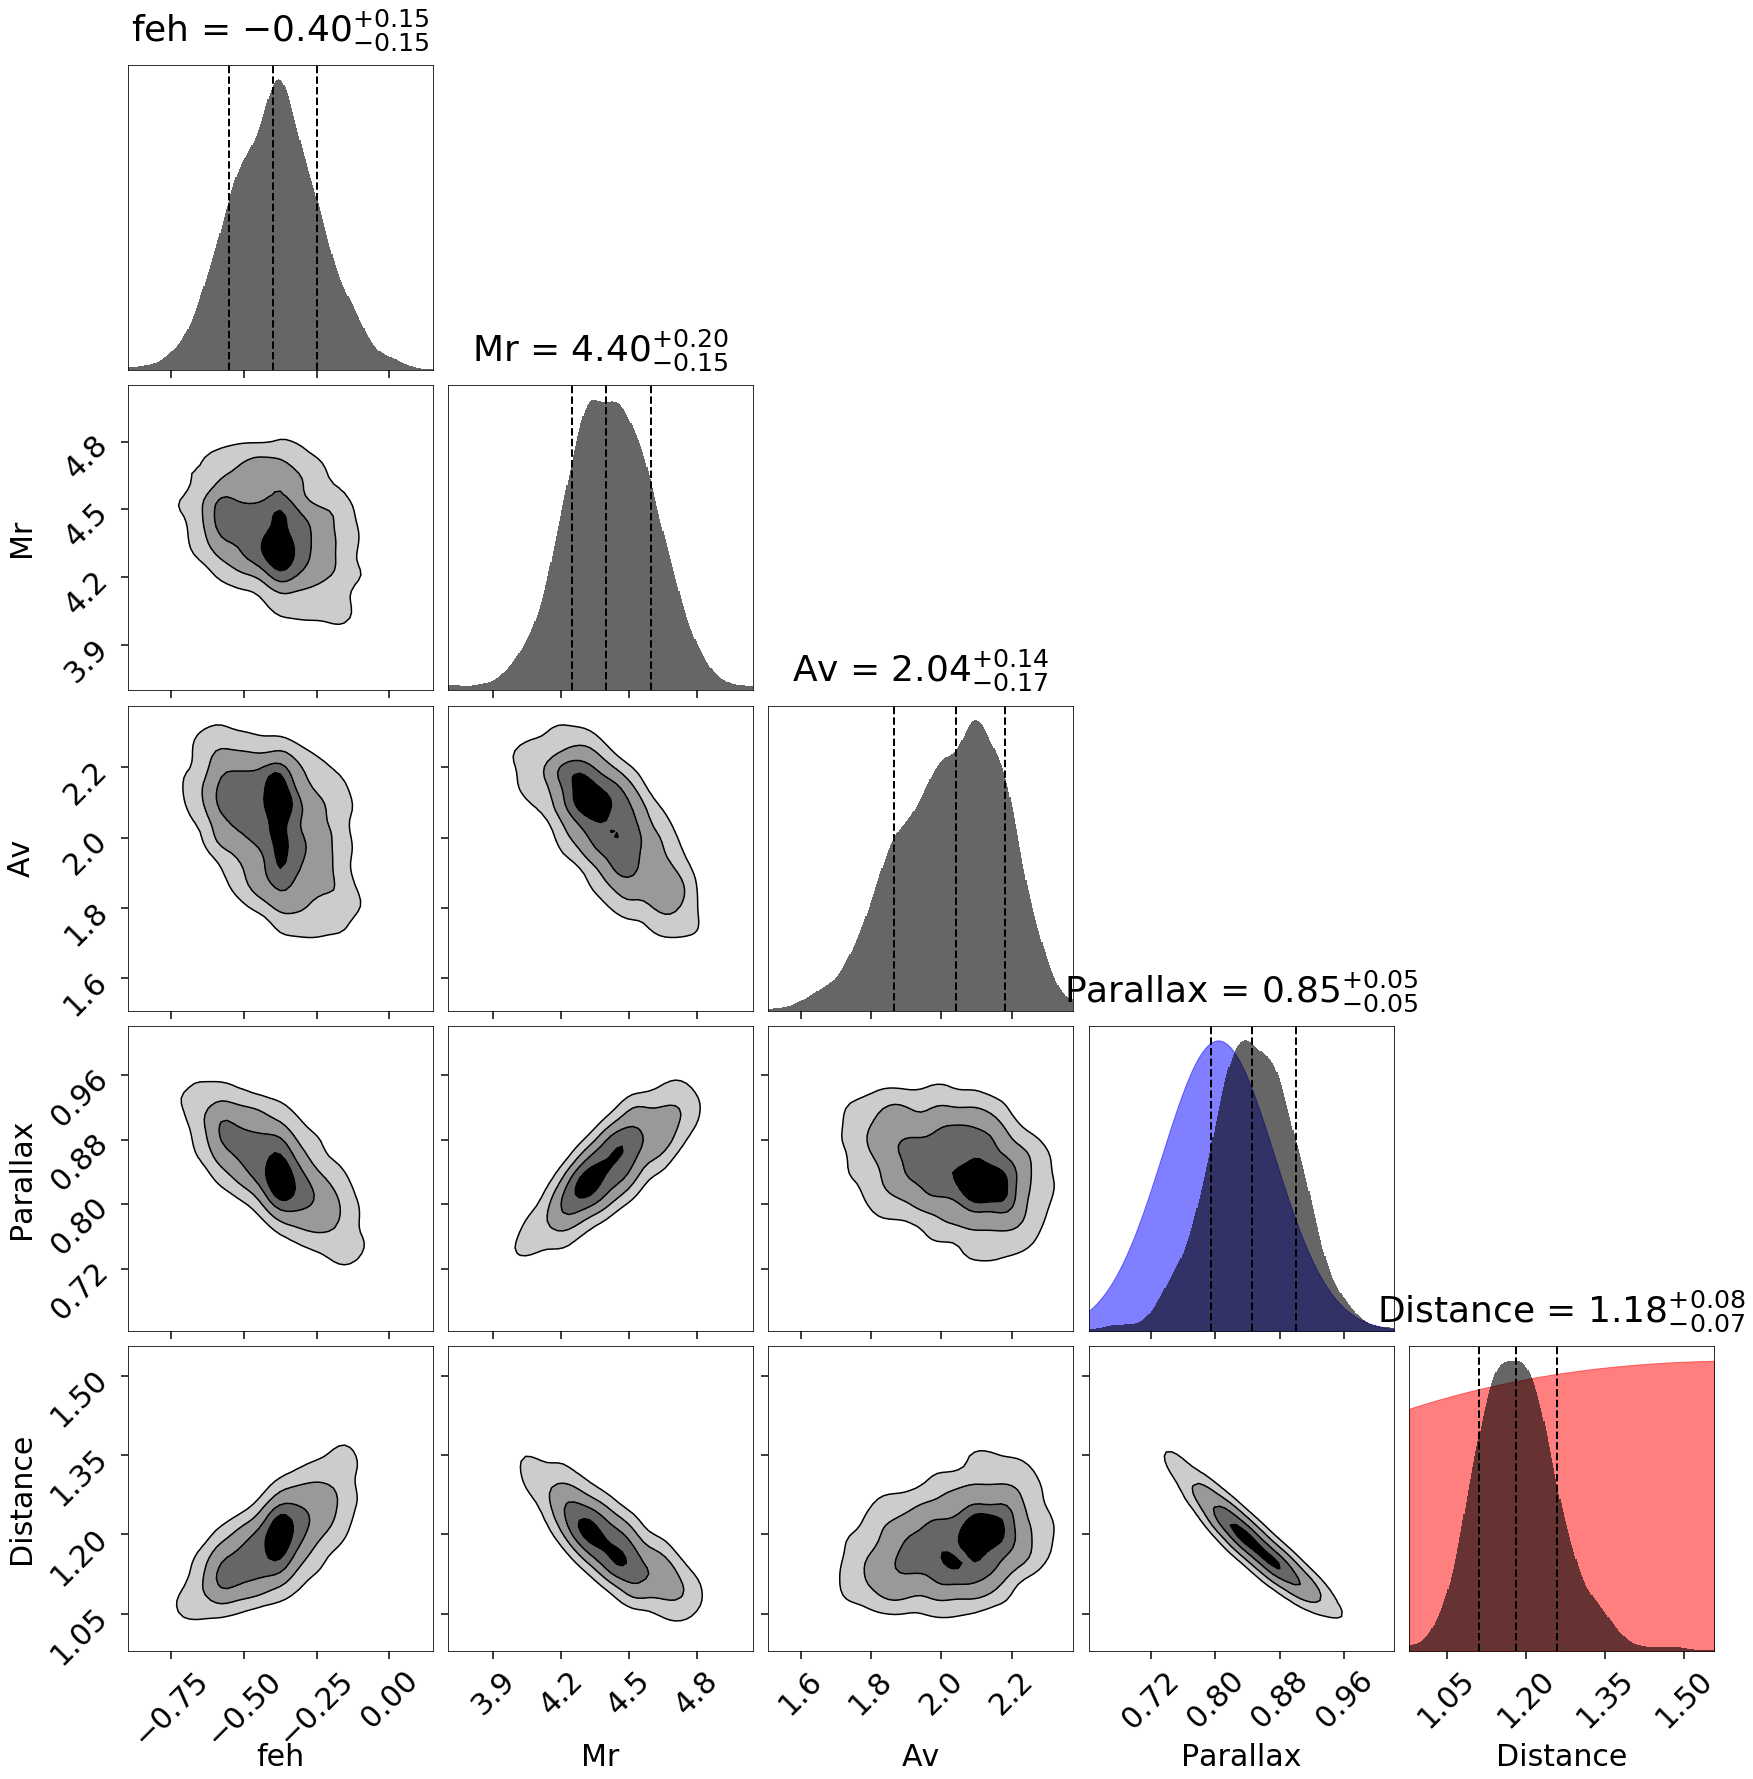

In [11]:
# plot snapshot of results
from brutus import plotting as bplot

i = 5

# Bayestar
print('Best-fit chi2:', chi2_bs[i])
fig, axes = bplot.cornerplot(idxs_bs[i], (dists_bs[i], reds_bs[i]),
                             labels_bs, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

Best-fit chi2: 1.289661


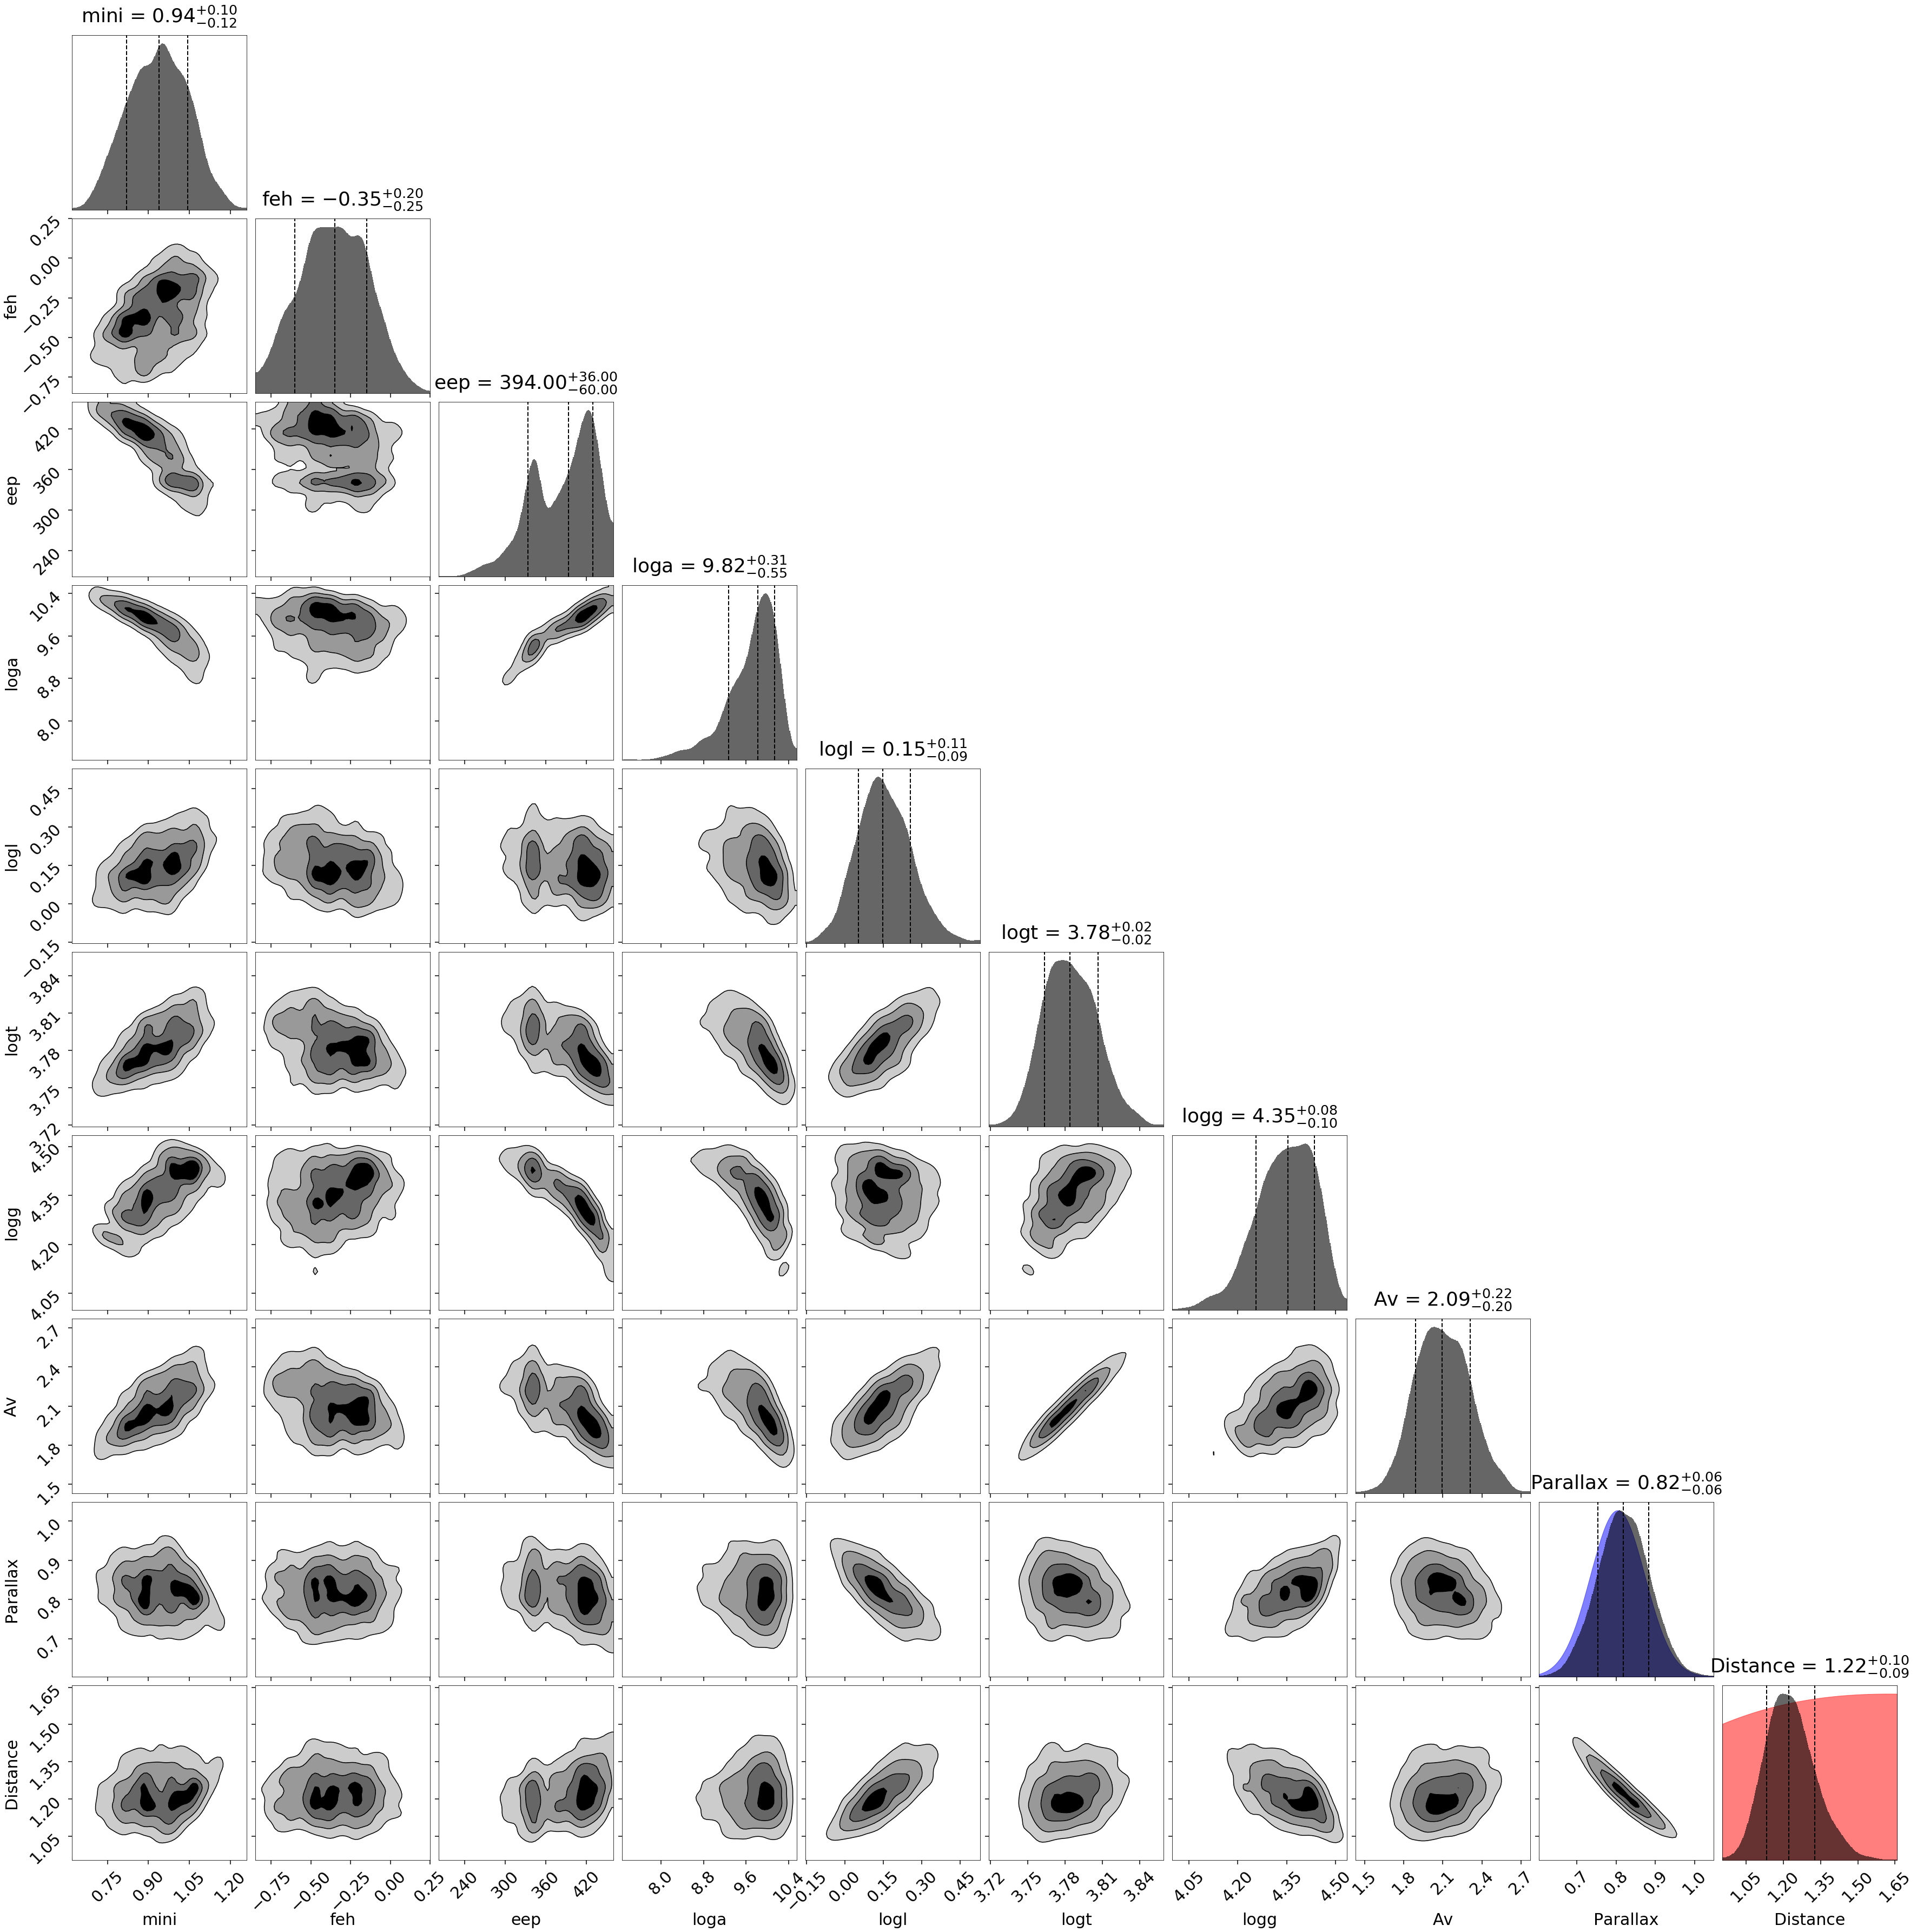

In [12]:
# MIST with gaia
print('Best-fit chi2:', chi2_mist[i])
fig, axes = bplot.cornerplot(idxs_mist[i], (dists_mist[i], reds_mist[i]),
                             labels_mist, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

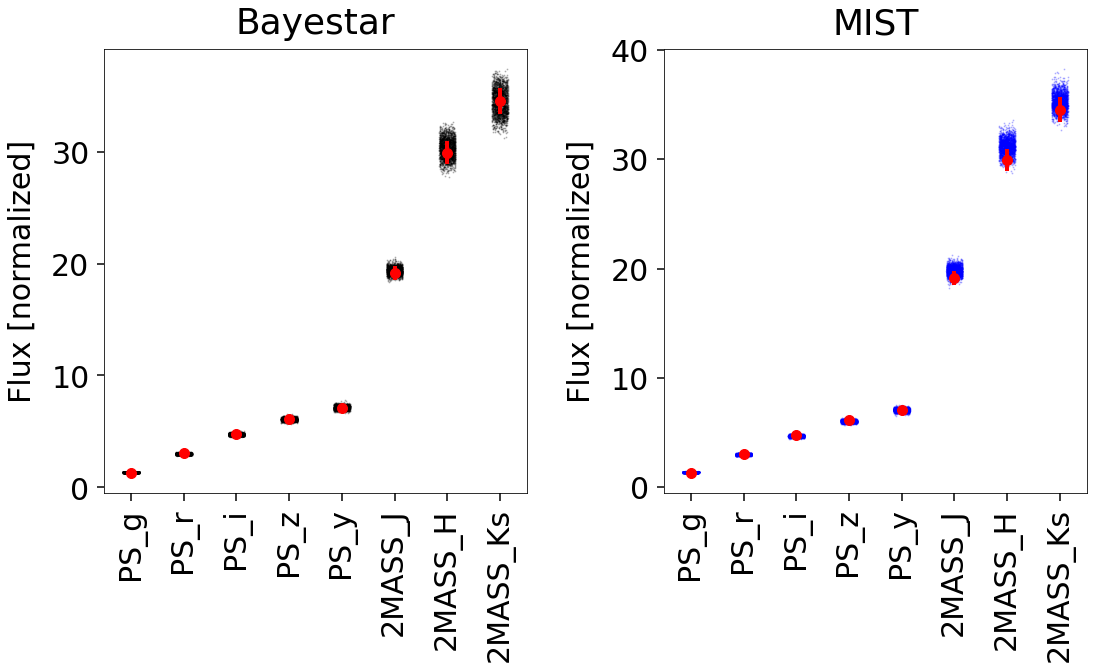

In [13]:
# plot SEDs
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
seds = fitting.get_seds(models_bs[idxs_bs[i]], av_bs[i], 
                        return_flux=True) / dists_bs[i][:, None]**2
plt.plot(np.arange(8)[:, None] + np.random.uniform(-0.15, 0.15, (8, 2000)), 
         seds.T * 1e7, 'k.', ms=2, alpha=0.2, zorder=1)
plt.errorbar(np.arange(8)[mask[i]], phot[i, mask[i]] * 1e7, 
             yerr=err[i, mask[i]]*1e7, fmt='ro', ms=10, lw=4, 
             zorder=2)
plt.xticks(np.arange(8), filters, rotation='vertical')
plt.ylabel('Flux [normalized]')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 2, 2)
seds = fitting.get_seds(models_mist[idxs_mist[i]], av_mist[i], 
                        return_flux=True) / dists_mist[i][:, None]**2
plt.plot(np.arange(8)[:, None] + np.random.uniform(-0.15, 0.15, (8, 2000)), 
         seds.T * 1e7, 'b.', ms=2, alpha=0.2, zorder=1)
plt.errorbar(np.arange(8)[mask[i]], phot[i, mask[i]] * 1e7, 
             yerr=err[i, mask[i]] * 1e7, fmt='ro', ms=10, lw=4, 
             zorder=2)
plt.xticks(np.arange(8), filters, rotation='vertical')
plt.ylabel('Flux [normalized]')
plt.title('MIST')
plt.tight_layout()

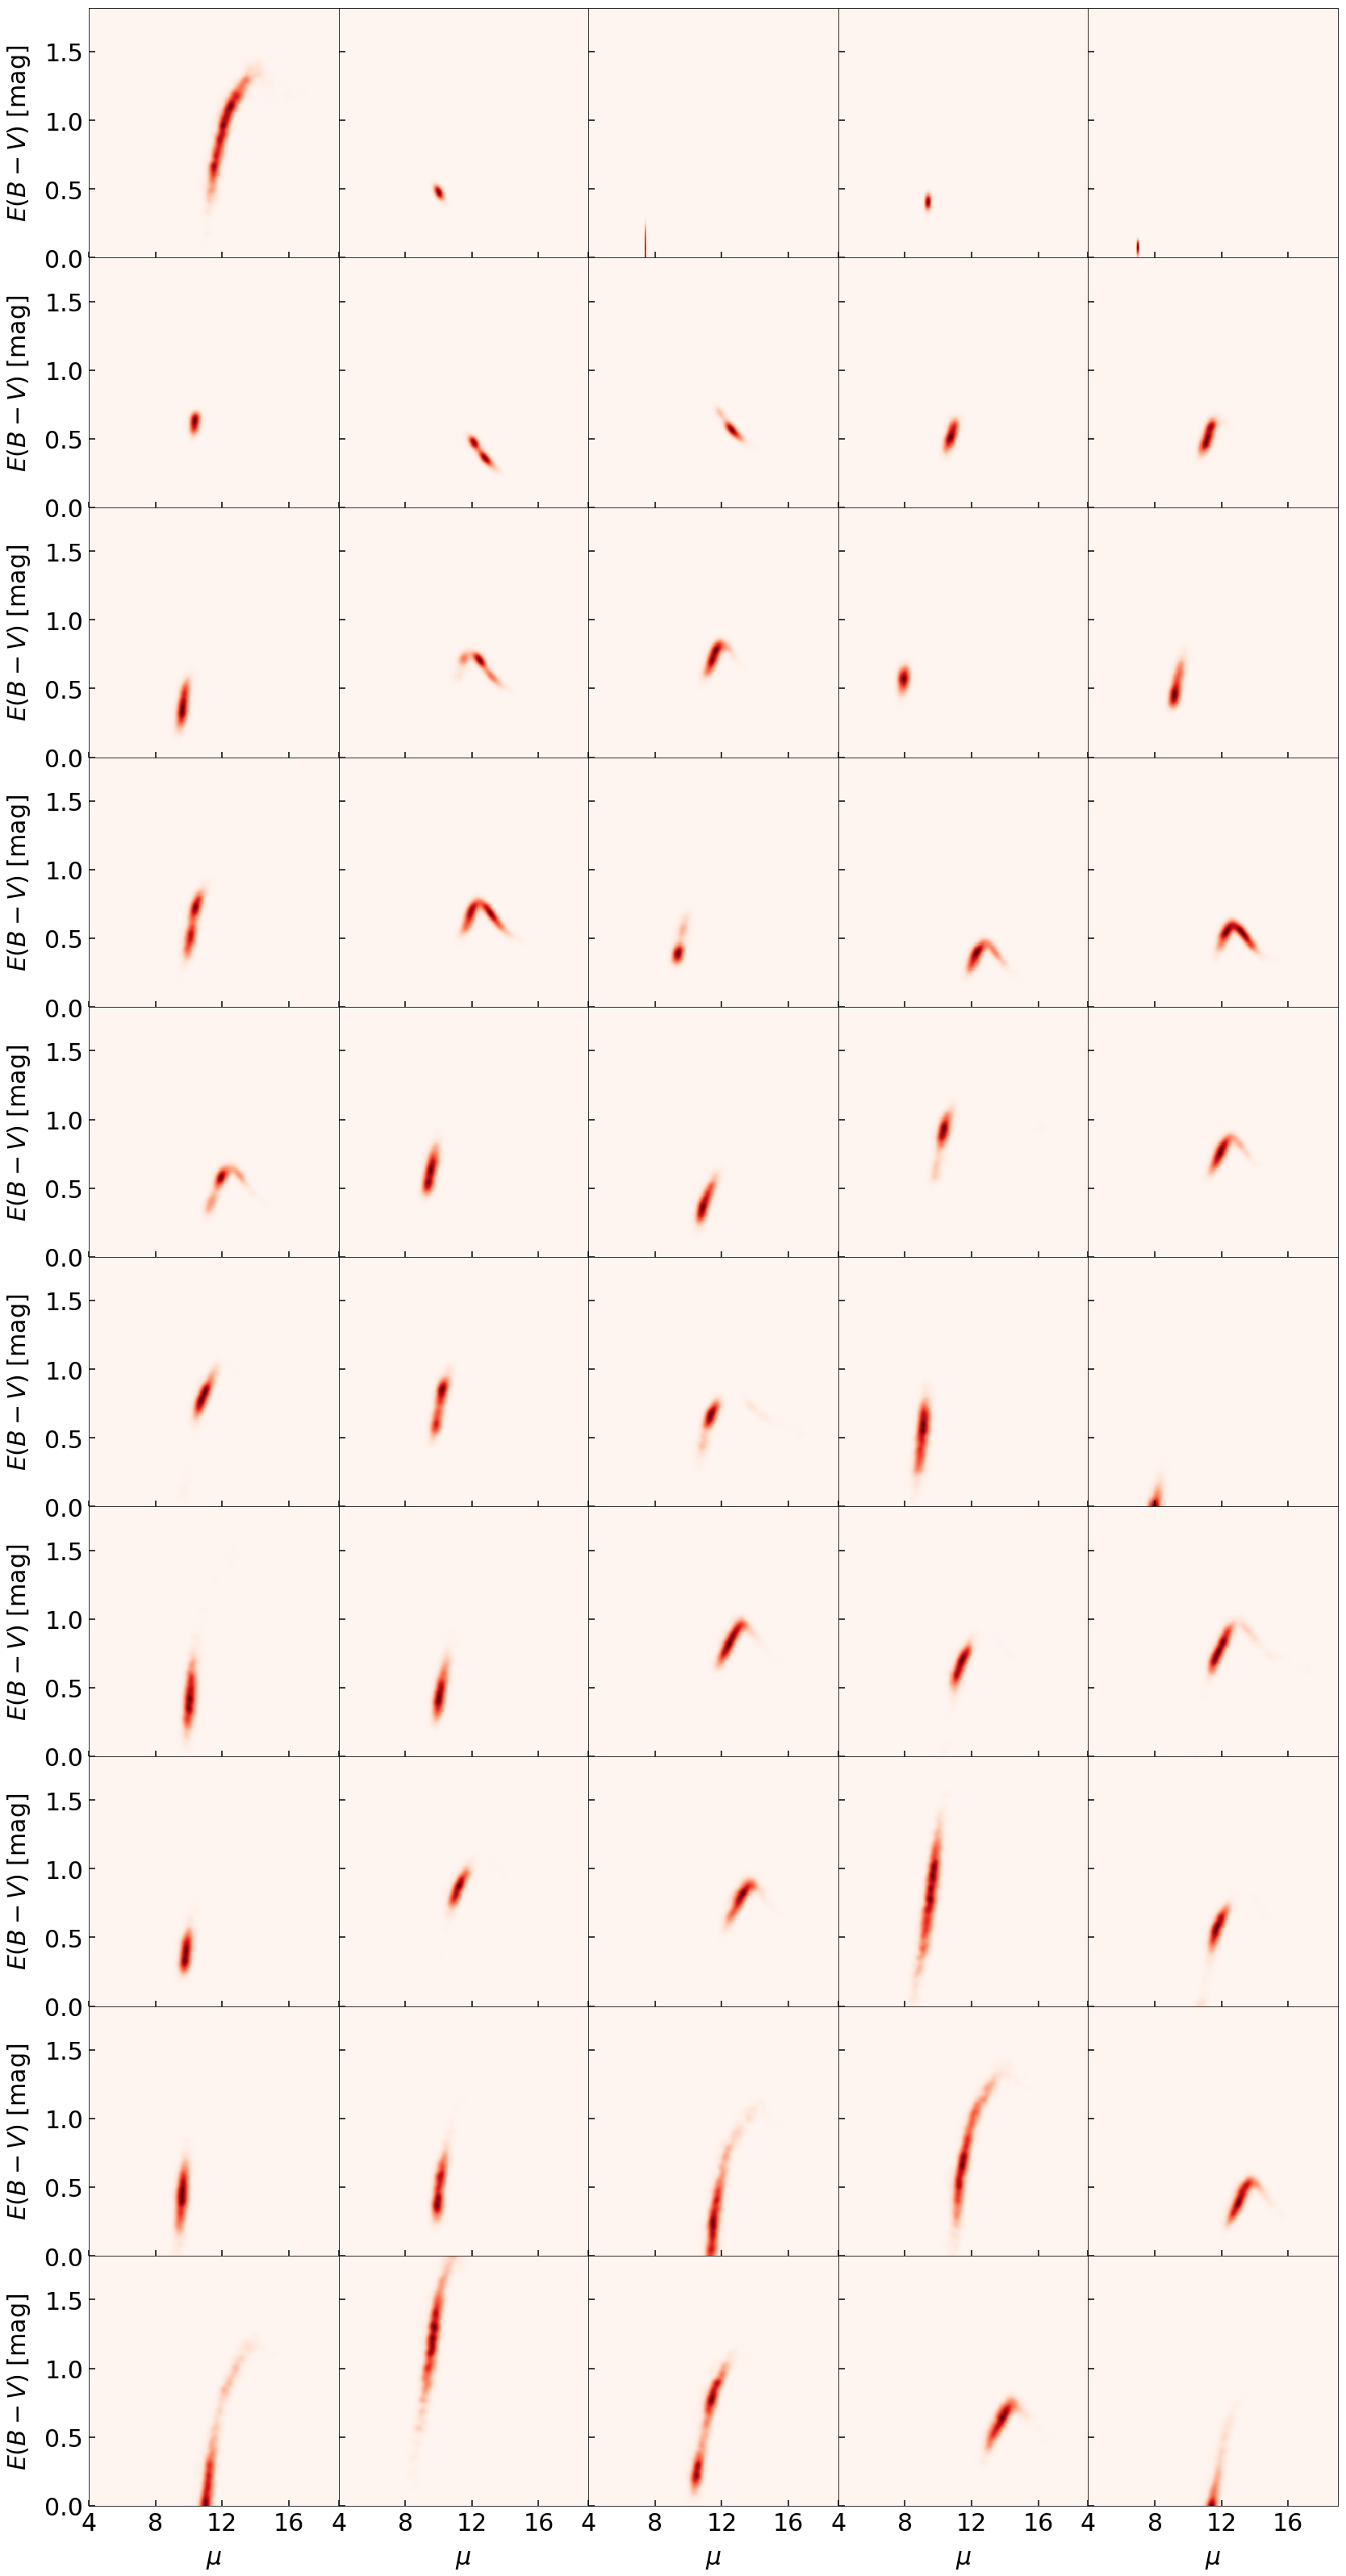

In [14]:
# Bayestar subset
xdim, ydim = 25, 50
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_bs[i], reds_bs[i]), 
                      parallax=parallax[i], 
                      parallax_err=parallax_err[i],
                      Rv=3.3, cmap='Reds')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])

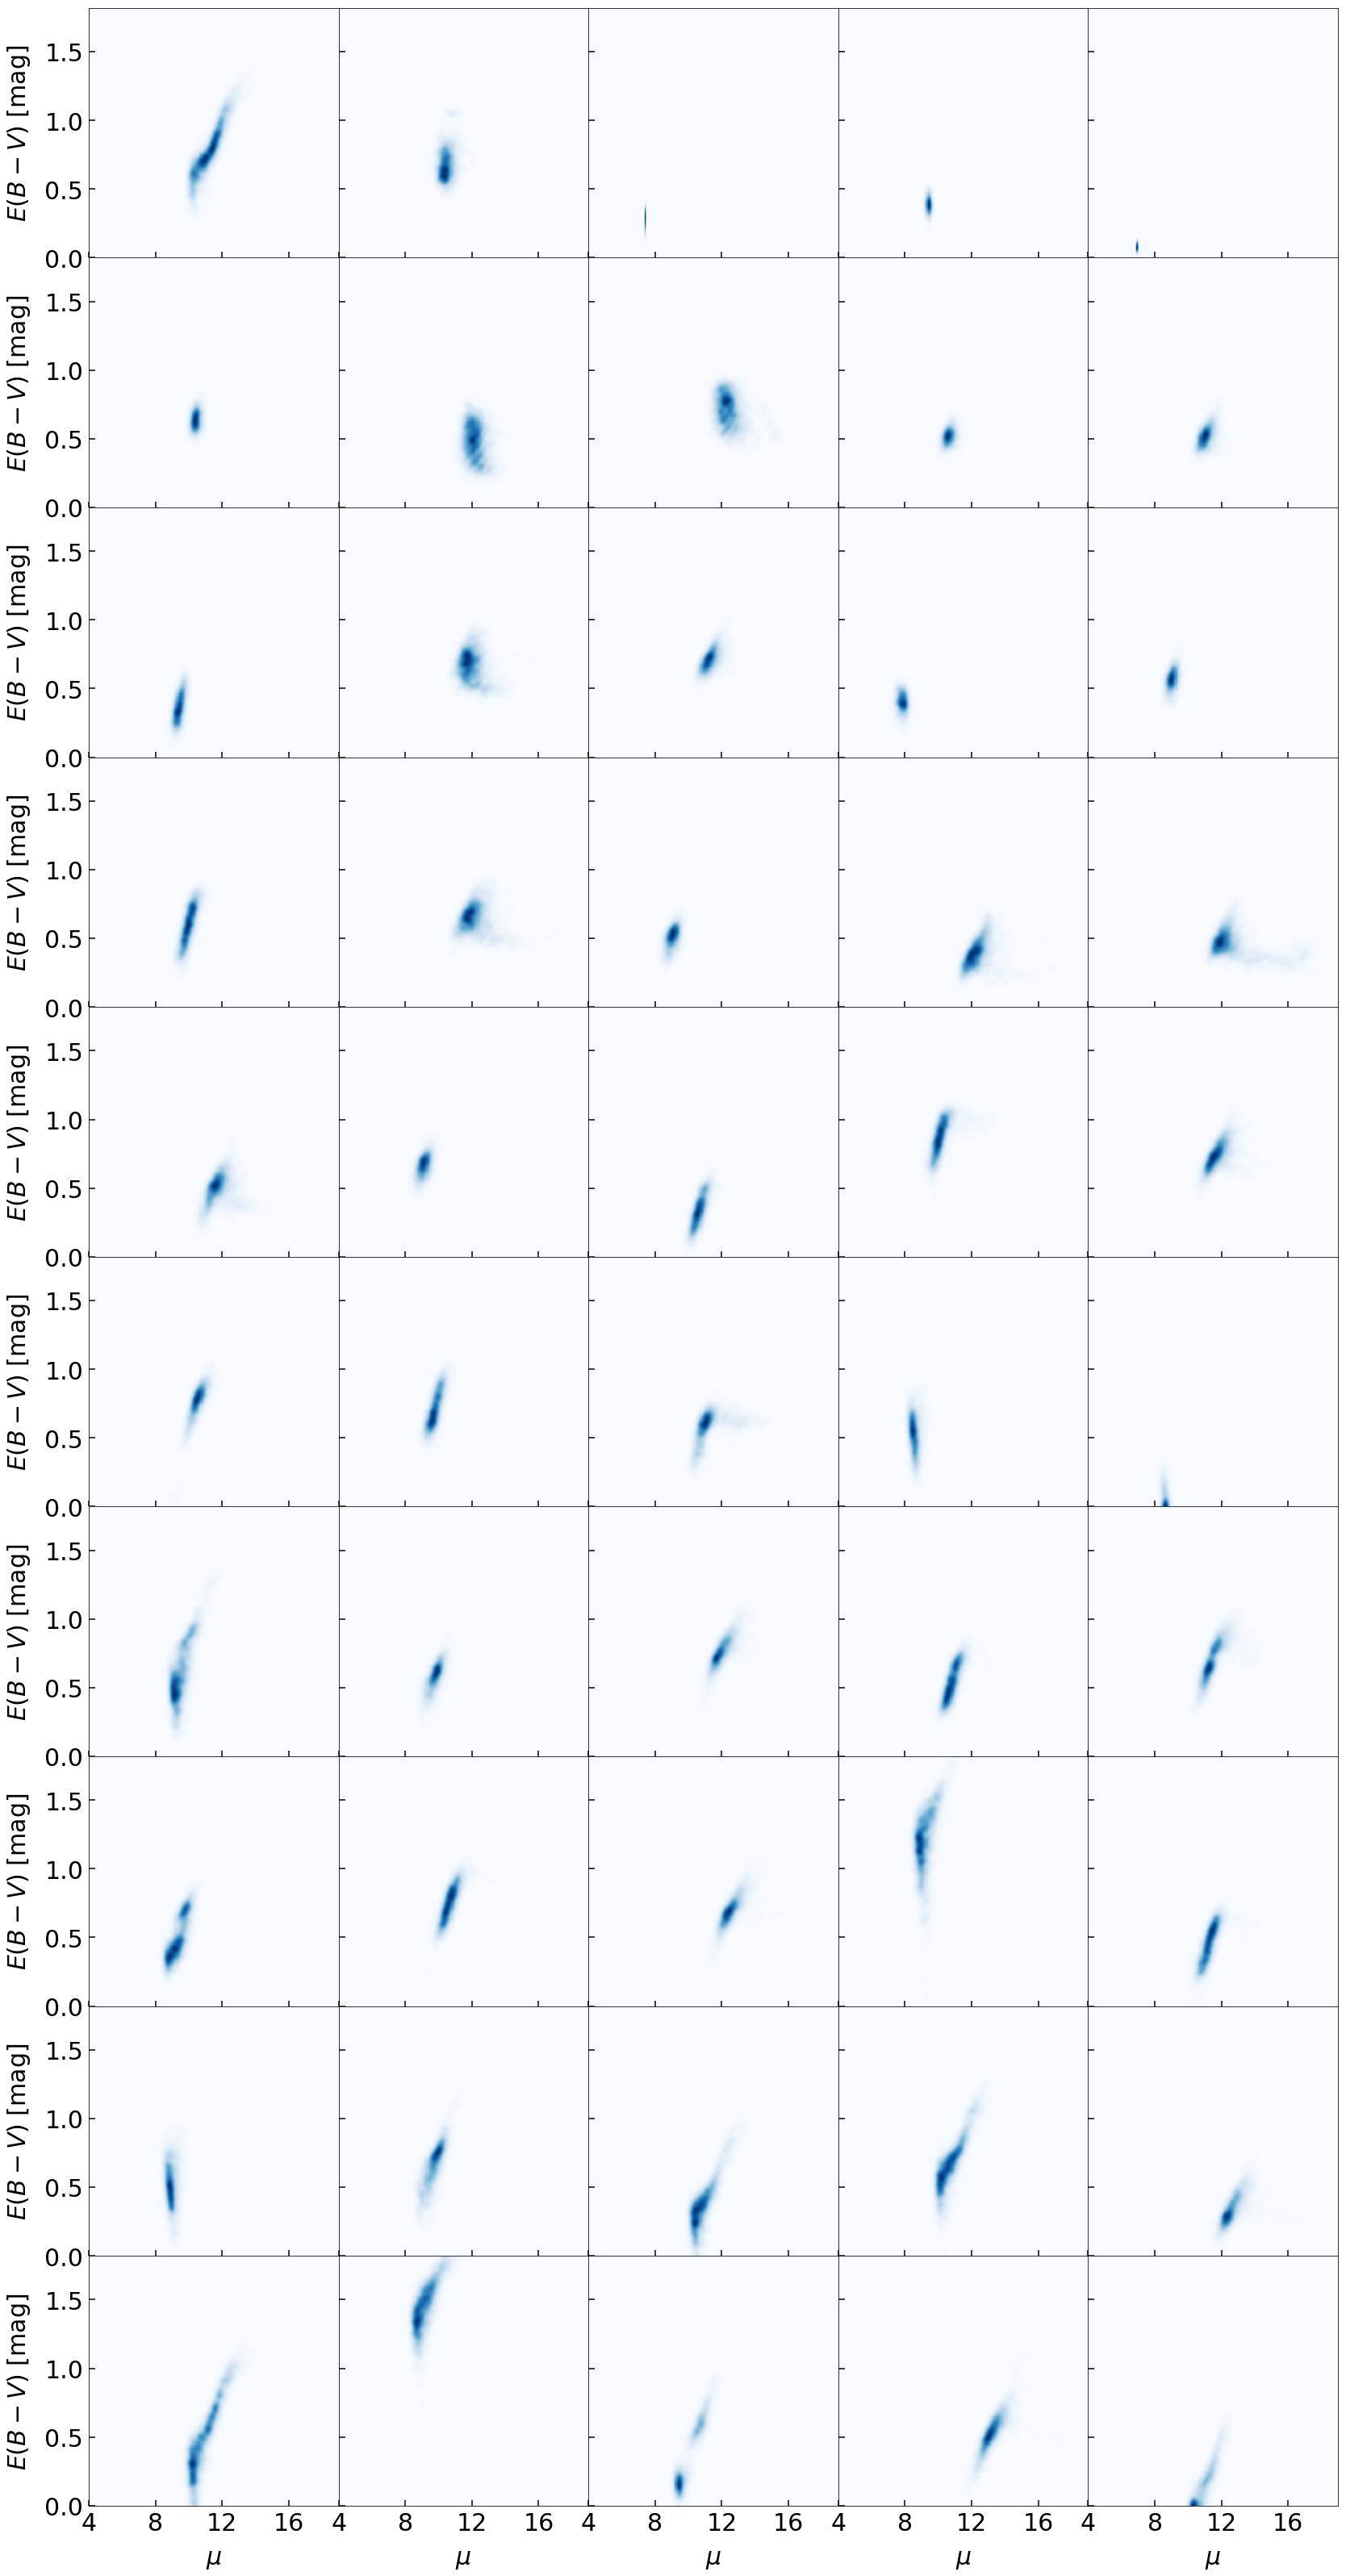

In [15]:
# MIST subset
xdim, ydim = 25, 50
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_mist[i], reds_mist[i]), 
                      parallax=parallax[i], 
                      parallax_err=parallax_err[i],
                      Rv=3.3, cmap='Blues')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])

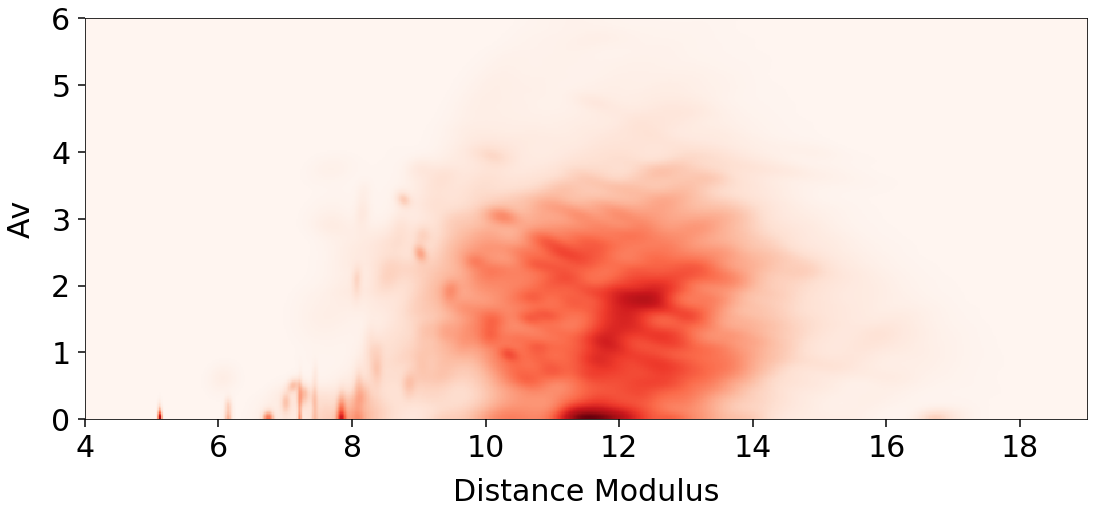

In [16]:
# plot stacked PDFs (Bayestar)
(pdfbin_bs, xedges, yedges) = brutus.pdf.bin_pdfs_distred((dists_bs, reds_bs),
                                                          parallaxes=parallax,
                                                          parallax_errors=parallax_err)
plt.figure(figsize=(16, 8))
plt.imshow(pdfbin_bs[good_bs].sum(axis=0).T, origin='lower', 
           extent=[4, 19, 0, 6], cmap='Reds')
plt.xlabel('Distance Modulus')
plt.ylabel('Av')
plt.tight_layout()

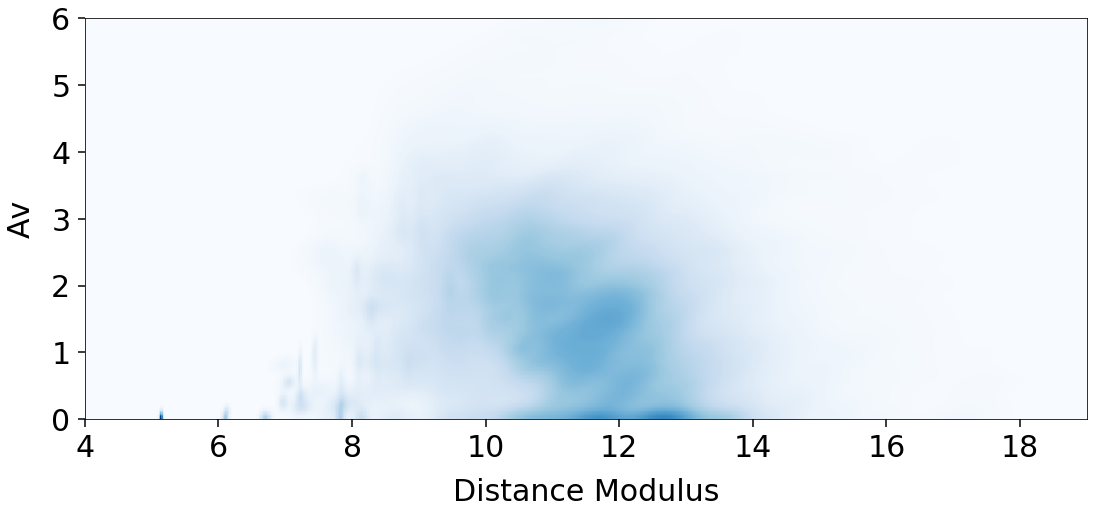

In [17]:
# generate binned CDFs (mist)
(pdfbin_mist, xedges, yedges) = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist),
                                                            parallaxes=parallax,
                                                            parallax_errors=parallax_err)
plt.figure(figsize=(16, 8))
plt.imshow(pdfbin_mist[good_mist].sum(axis=0).T, origin='lower', 
           extent=[4, 19, 0, 6], cmap='Blues')
plt.xlabel('Distance Modulus')
plt.ylabel('Av')
plt.tight_layout()

# Line-of-Sight: Binned Posteriors

In [19]:
# generate binned CDFs (Bayestar)
(cdfbin_bs, xedges, yedges) = brutus.pdf.bin_pdfs_distred((dists_bs, reds_bs), 
                                                          cdf=True, Rv=None,
                                                          parallaxes=parallax,
                                                          parallax_errors=parallax_err)

In [20]:
# fit dust along the LOS w/ dynesty
import dynesty
from brutus import los

loglikelihood = los.LOS_clouds_loglike_bin  # log-likelihood (binned)
prior_transform = los.LOS_clouds_priortransform  # prior transform

nclouds = 1  # number of clouds
smooth = False
ndim = 2 * nclouds + 2 * smooth + 2  # number of parameters

# sample
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (4., 12.),
                                               'smooth': smooth},
                                logl_args=[cdfbin_bs[good_bs], 
                                           xedges, yedges])
sampler.run_nested(dlogz=0.01)

# grab results
results_bs = sampler.results

iter: 11379+500 | bound: 98 | nc: 1 | ncall: 257866 | eff(%):  4.607 | loglstar:   -inf < -10848.564 <    inf | logz: -10866.690 +/-  0.176 | dlogz:  0.000 >  0.010            

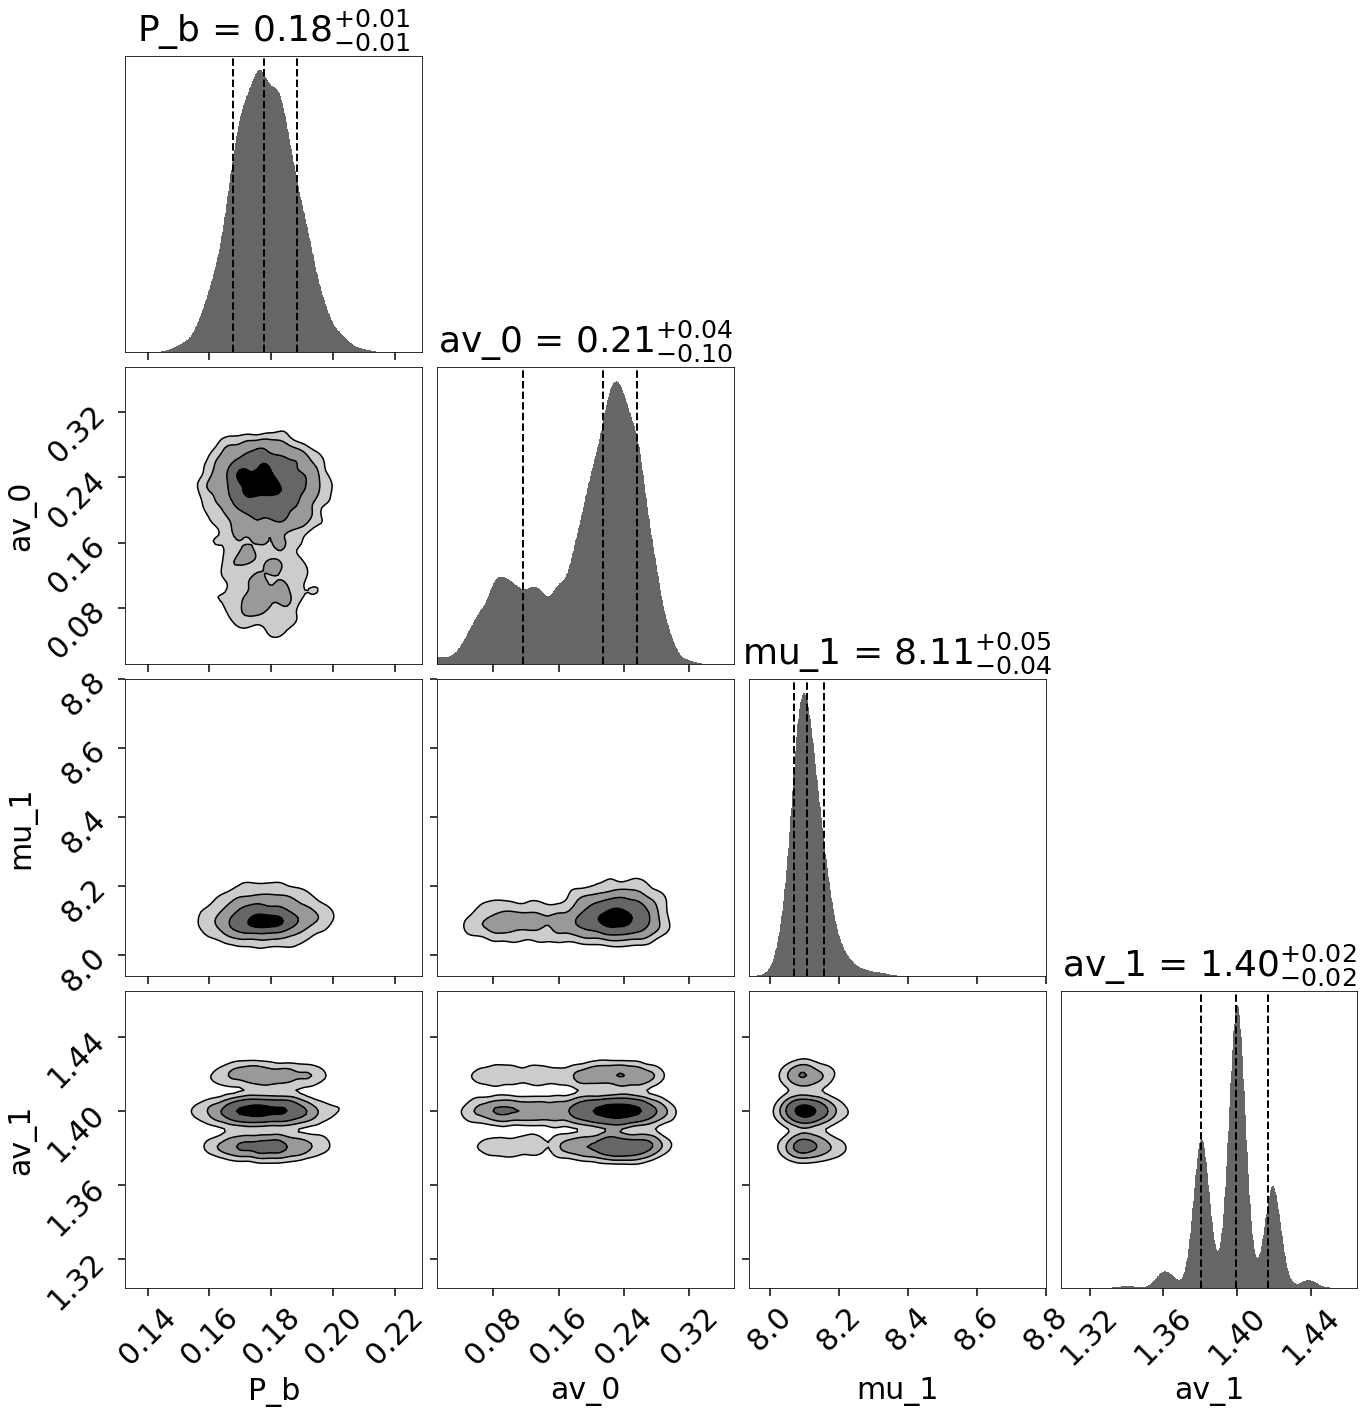

In [21]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(results_bs, labels=['P_b', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True,
                            fig=plt.subplots(4, 4, figsize=(20, 20)))

In [22]:
# generate binned CDFs (MIST)
(cdfbin_mist, xedges, yedges) = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist), 
                                                            cdf=True, Rv=None,
                                                            parallaxes=parallax,
                                                            parallax_errors=parallax_err)

In [23]:
# fit dust along the LOS w/ dynesty
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (4., 12.),
                                               'smooth': smooth},
                                logl_args=[cdfbin_mist[good_mist], 
                                           xedges, yedges])
sampler.run_nested(dlogz=0.01)
results_mist = sampler.results

iter: 11314+500 | bound: 96 | nc: 1 | ncall: 254850 | eff(%):  4.636 | loglstar:   -inf < -10499.295 <    inf | logz: -10517.290 +/-  0.176 | dlogz:  0.000 >  0.010            

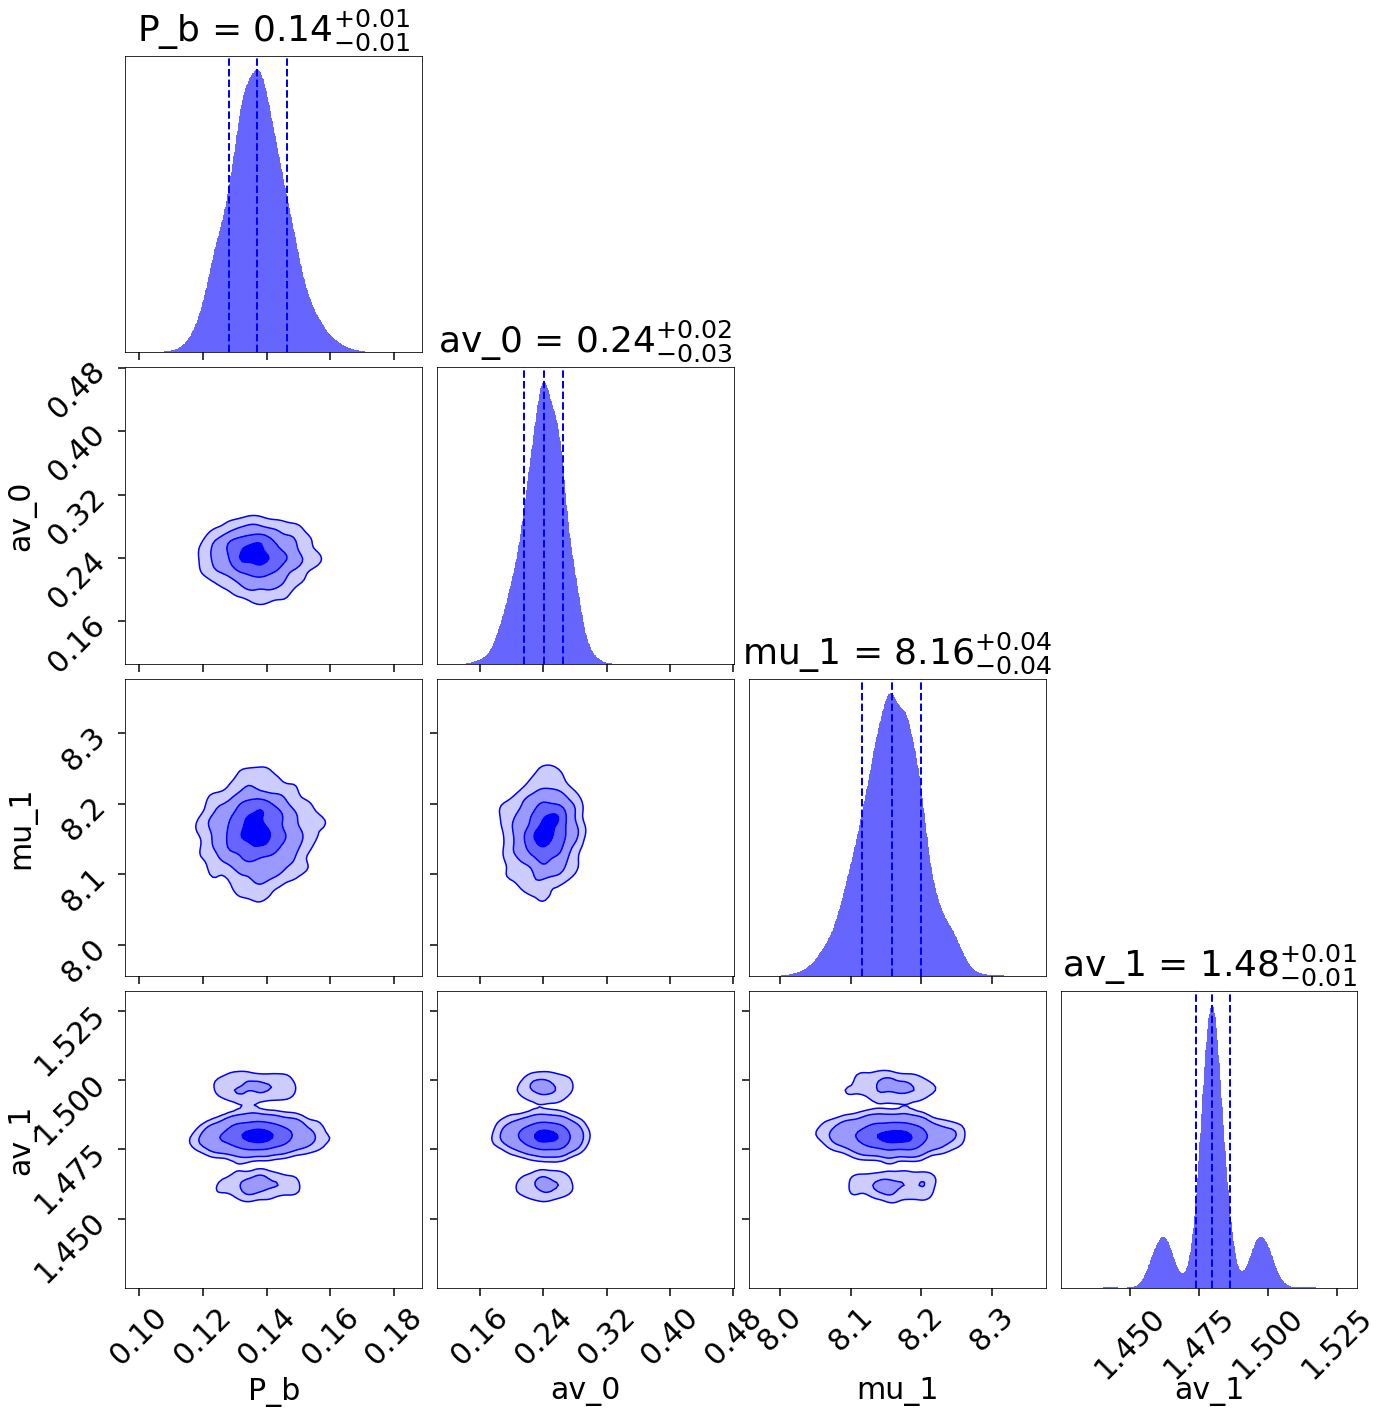

In [24]:
# plot results
fig, ax = dyplot.cornerplot(results_mist, labels=['P_b', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True, color='blue',
                            fig=plt.subplots(4, 4, figsize=(20, 20)))

# Line-of-Sight: Posterior Samples

In [25]:
# fit dust along the LOS w/ dynesty
from brutus import los
import dynesty

dms_bs = 5. * np.log10(dists_bs) + 10.  # convert to distance modulus

loglikelihood = los.LOS_clouds_loglike_samples  # log-likelihood (samples)
prior_transform = los.LOS_clouds_priortransform  # prior transform

nclouds = 1  # number of clouds
smooth = True
ndim = 2 * nclouds + 2 * smooth + 2  # number of parameters

# sample
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (4., 12.),
                                               'smooth': smooth},
                                logl_args=[dms_bs[good_bs], reds_bs[good_bs]])
sampler.run_nested(dlogz=0.01)

# grab results
results_bs2 = sampler.results

iter: 15633+500 | bound: 205 | nc: 1 | ncall: 364909 | eff(%):  4.421 | loglstar:   -inf < -2090.756 <    inf | logz: -2117.384 +/-  0.211 | dlogz:  0.000 >  0.010            

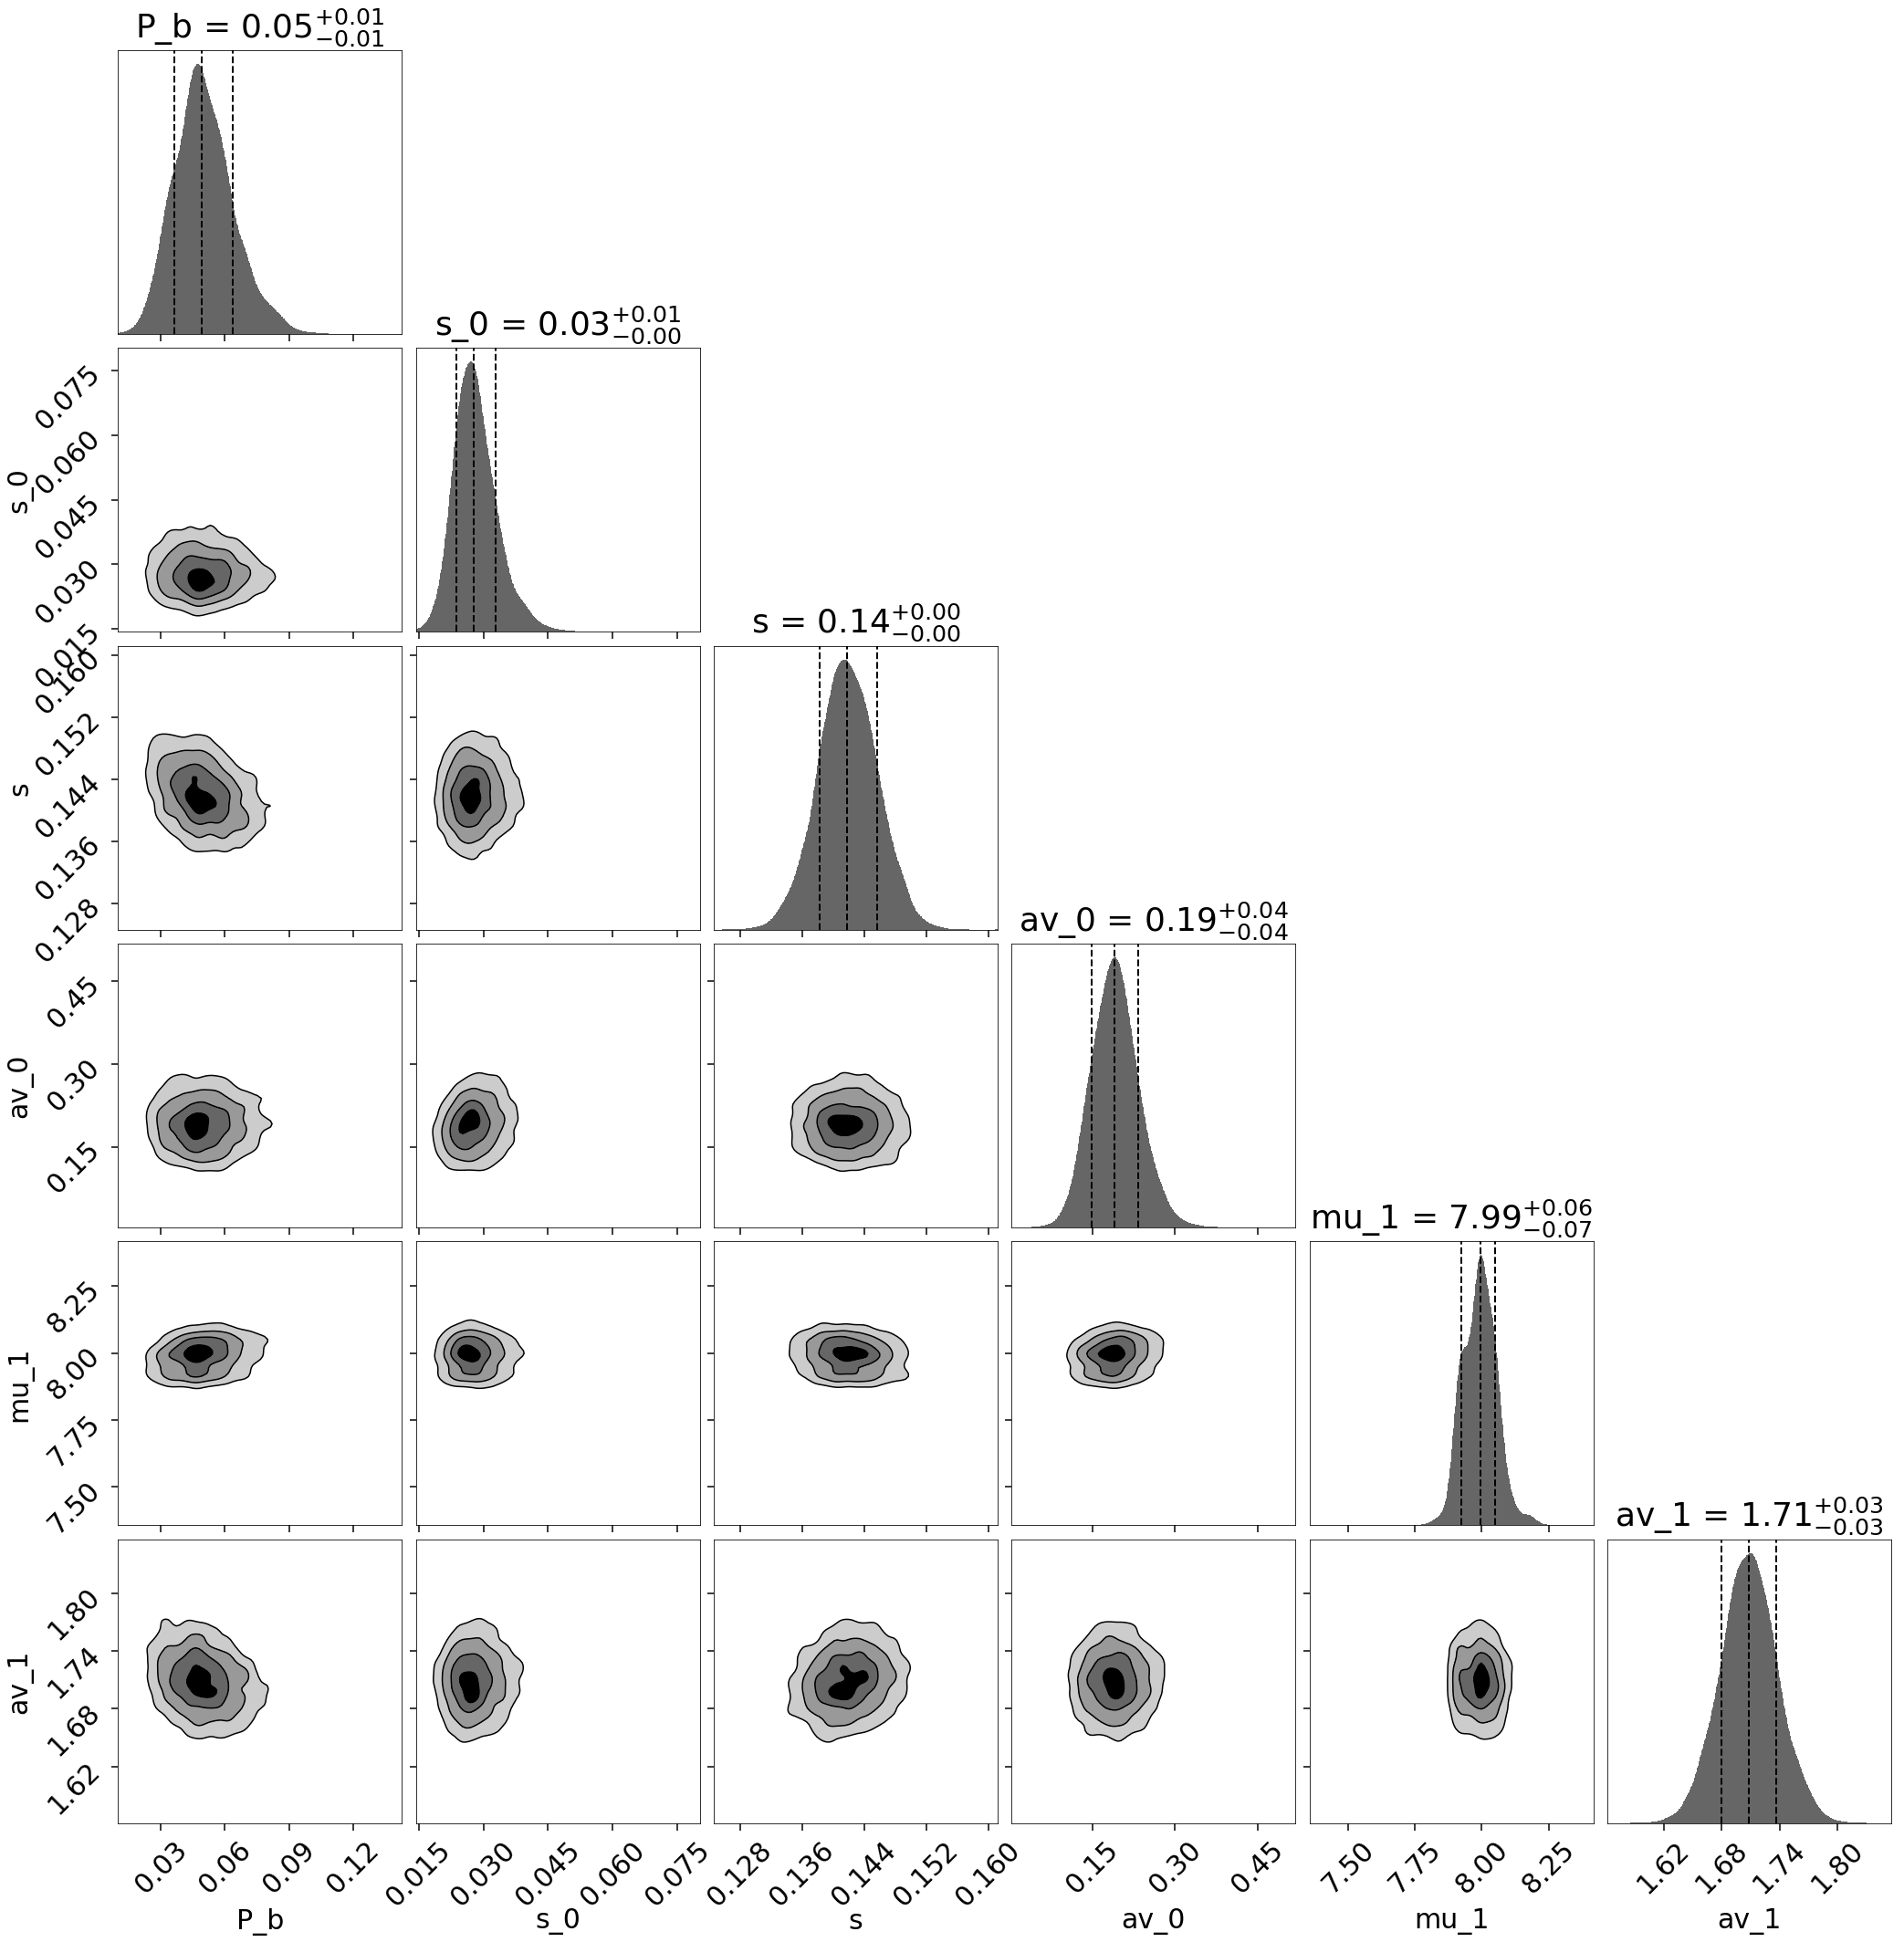

In [26]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(results_bs2, labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True,
                            fig=plt.subplots(6, 6, figsize=(30, 30)))

In [27]:
# fit dust along the LOS w/ dynesty

dms_mist = 5. * np.log10(dists_mist) + 10.  # convert to distance modulus

# sample
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (4., 12.),
                                               'smooth': smooth},
                                logl_args=[dms_mist[good_mist], reds_mist[good_mist]])
sampler.run_nested(dlogz=0.01)

# grab results
results_mist2 = sampler.results

iter: 13611+500 | bound: 161 | nc: 1 | ncall: 317366 | eff(%):  4.446 | loglstar:   -inf < -2154.225 <    inf | logz: -2176.812 +/-  0.197 | dlogz:  0.000 >  0.010            

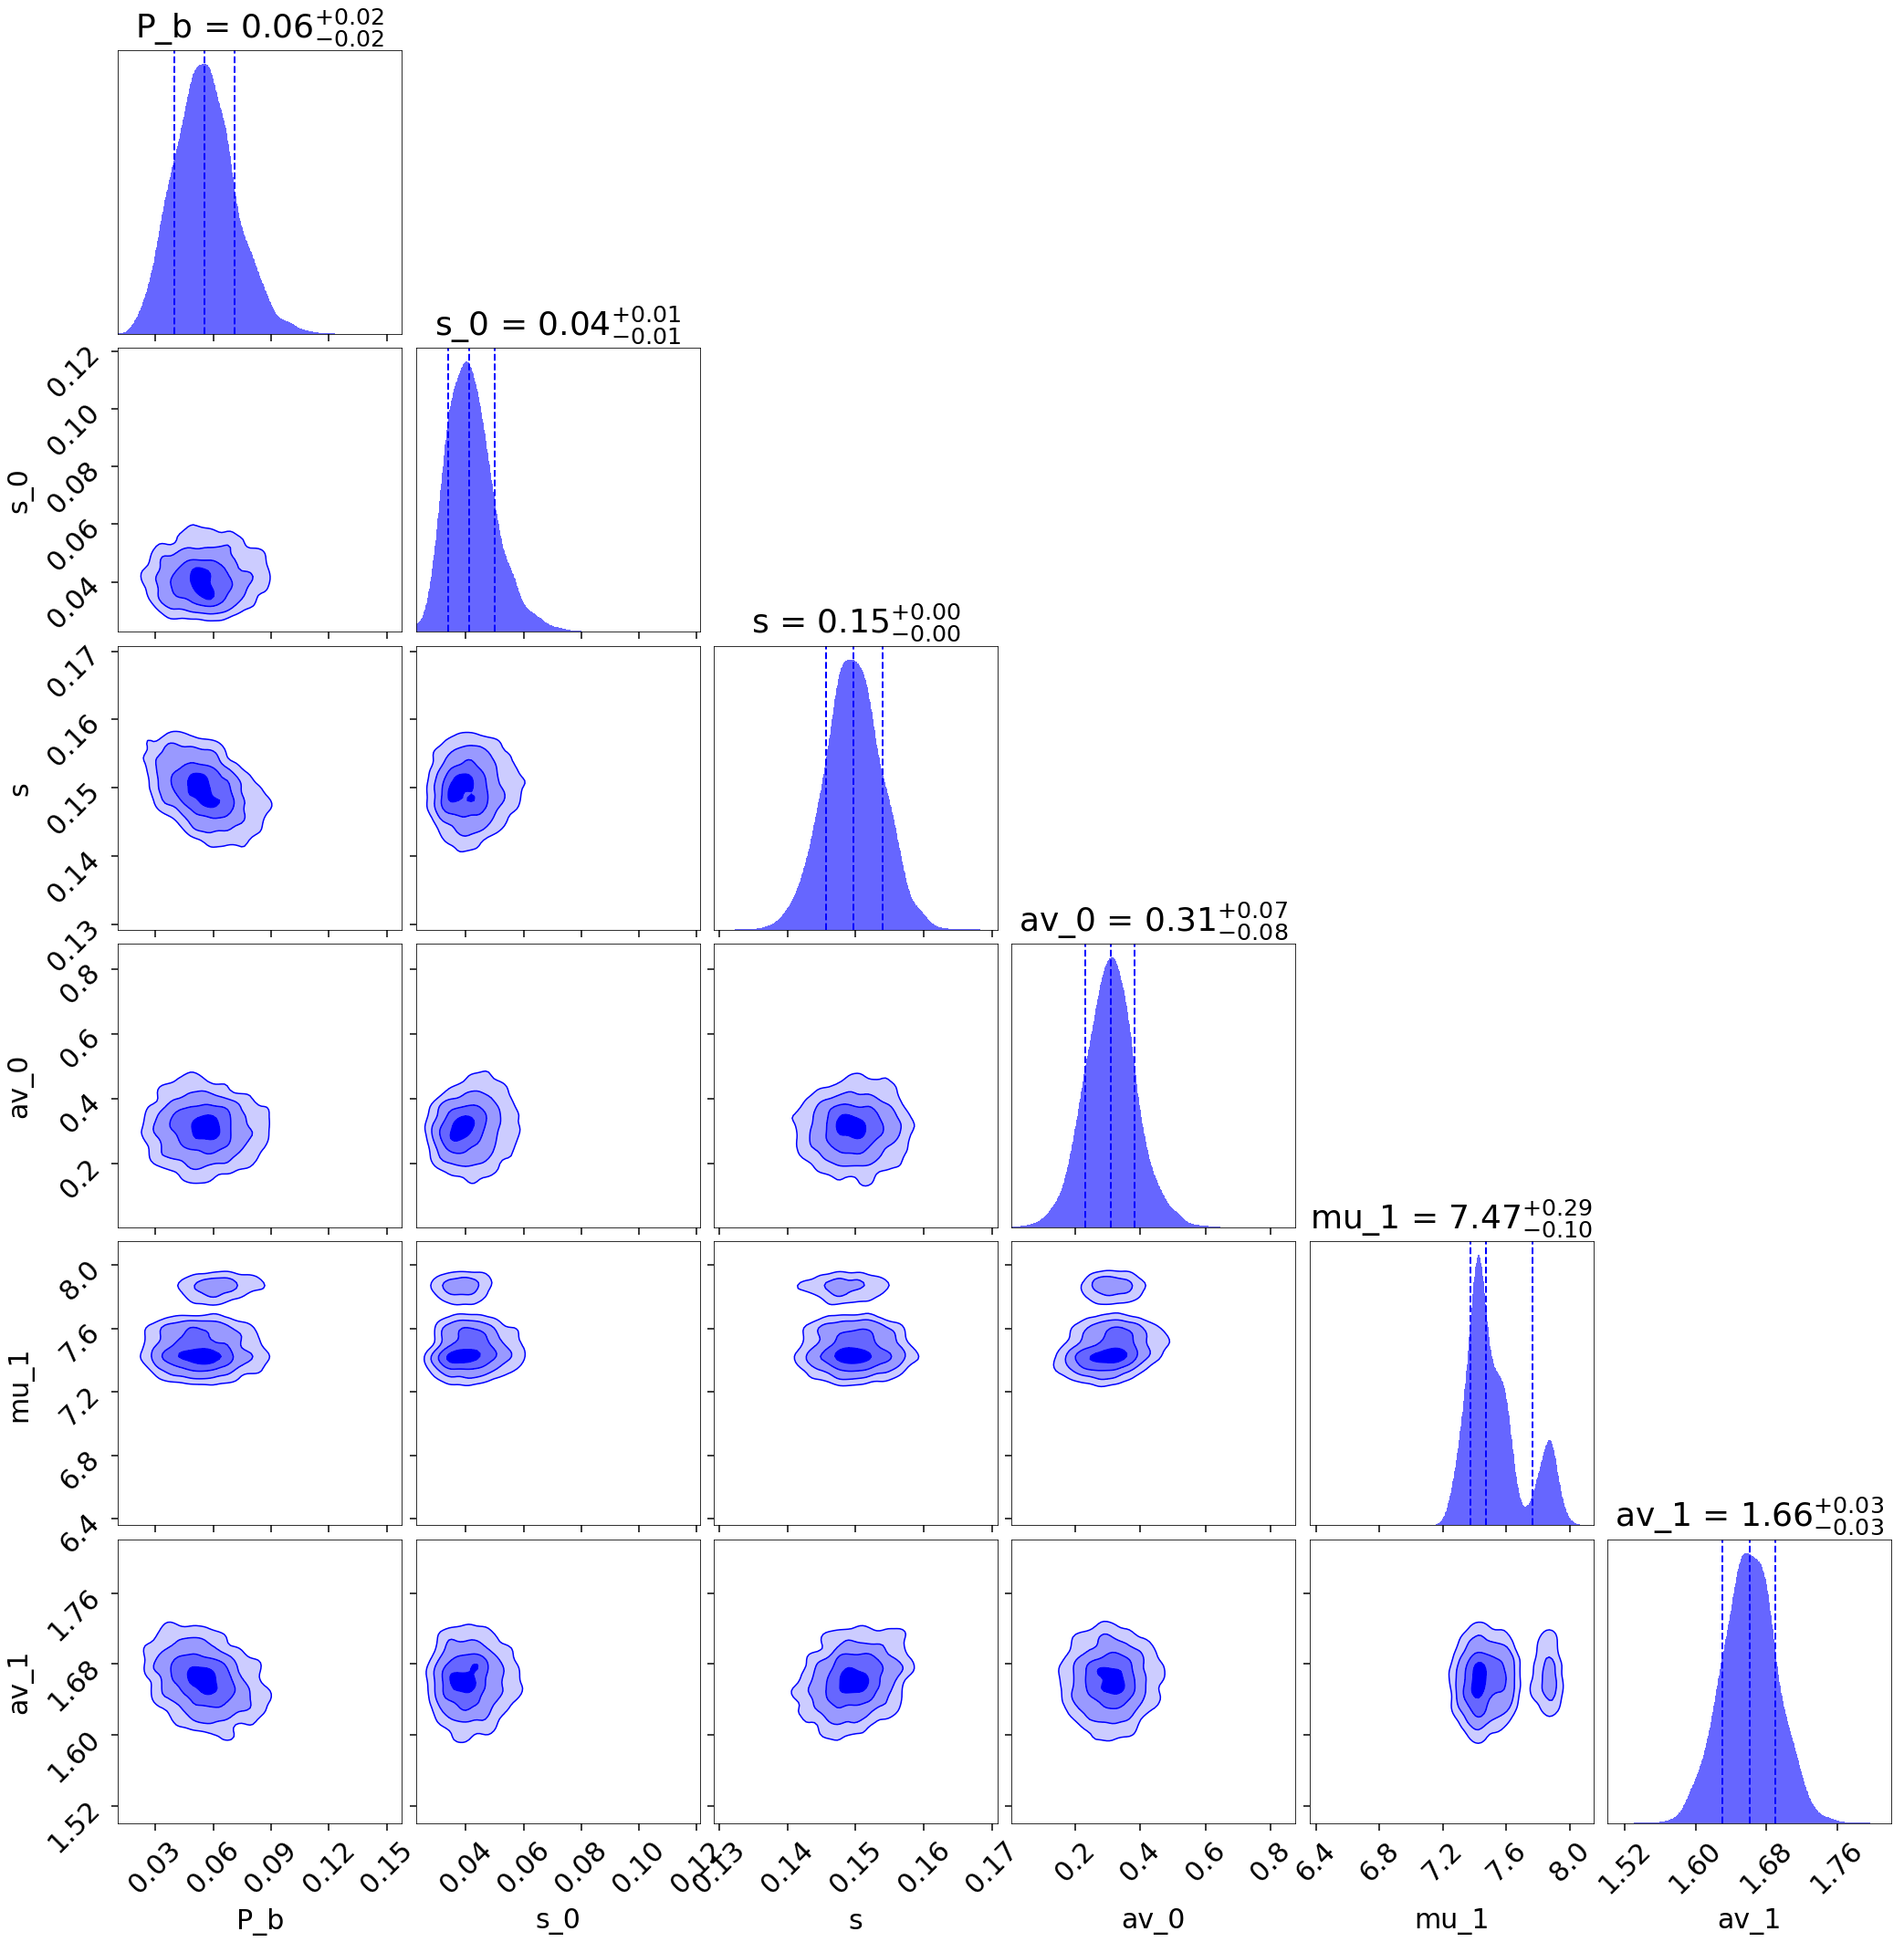

In [28]:
# plot results
fig, ax = dyplot.cornerplot(results_mist2, labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True, color='blue',
                            fig=plt.subplots(6, 6, figsize=(30, 30)))